In [67]:
##CONSTRUCTION MODEL FOR PINHIBENS DSM17395

#importing packages
from cobra.io import read_sbml_model, write_sbml_model, save_json_model
import numpy as np

In [68]:
#creating model from NCBI database
!carve --fbc2 --refseq GCF_000154765.2 -o pinhibens_DSM17395.xml
model = read_sbml_model('pinhibens_DSM17395.xml')

Traceback (most recent call last):
  File "/Users/marta/opt/anaconda3/bin/carve", line 5, in <module>
    from carveme.cli.carve import main
  File "/Users/marta/opt/anaconda3/lib/python3.8/site-packages/carveme/__init__.py", line 14, in <module>
    set_default_solver(config.get('solver', 'default_solver'))
  File "/Users/marta/opt/anaconda3/lib/python3.8/site-packages/reframed/solvers/__init__.py", line 60, in set_default_solver
    raise RuntimeError(f"Solver {solvername} not available.")
RuntimeError: Solver cplex not available.


In [69]:
#gap filling the model with rich medium (LB)

In [70]:
%%time
!carve --refseq GCF_000154765.2 --output pinhibens_DSM17395_LB.xml --gapfill LB --init LB

Traceback (most recent call last):
  File "/Users/marta/opt/anaconda3/bin/carve", line 5, in <module>
    from carveme.cli.carve import main
  File "/Users/marta/opt/anaconda3/lib/python3.8/site-packages/carveme/__init__.py", line 14, in <module>
    set_default_solver(config.get('solver', 'default_solver'))
  File "/Users/marta/opt/anaconda3/lib/python3.8/site-packages/reframed/solvers/__init__.py", line 60, in set_default_solver
    raise RuntimeError(f"Solver {solvername} not available.")
RuntimeError: Solver cplex not available.
CPU times: user 17.8 ms, sys: 19.1 ms, total: 36.9 ms
Wall time: 1.15 s


In [71]:
model = read_sbml_model('pinhibens_DSM17395_LB.xml')

In [72]:
#solving problems about the SBML file -it was missing "boundaryCondition="false""
for met in model.metabolites:
    met.boundaryCondition = "false"

In [73]:
#creating new file so the SBML problem is fixed
write_sbml_model(model, "pinhibens_DSM17395_ok.xml")
model = read_sbml_model('pinhibens_DSM17395_ok.xml')

In [74]:
##CONSTRUCTION AND HIGH-LEVEL ANALYSIS OF STOICHIOMETRIC MATRIX (S)

#creating the stoichiometric matrix from the model and cheching how sparse it is:
from cobra.util import create_stoichiometric_matrix

In [75]:
S=create_stoichiometric_matrix(model)
S.shape

(1722, 2563)

In [76]:
nonzeros=np.count_nonzero(S)
zeros=S[np.where(S == 0)].size
percent_nonzeros=(nonzeros/(zeros+nonzeros))*100
print("Number of Zeroes in S -->",zeros)
print("Number of non-Zeroes in S -->",nonzeros)
print("Percentage of non-zero elements in S-->",round(percent_nonzeros,2),"%")

Number of Zeroes in S --> 4402733
Number of non-Zeroes in S --> 10753
Percentage of non-zero elements in S--> 0.24 %


In [77]:
#finding the degrees of freedom (F) of our model
from numpy.linalg import matrix_rank

In [78]:
rank_S=matrix_rank(S, tol=None, hermitian=False)
dimS=S.shape
F=dimS[1]-rank_S
print("Degrees of freedom:",F)

Degrees of freedom: 893


In [79]:
#visualization of stoichiometric matrix (S)

import matplotlib.pyplot as plt

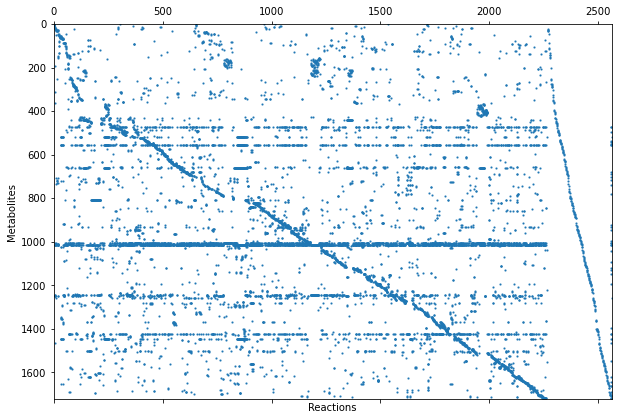

In [80]:
plt.figure(figsize=(10,10))
plt.spy(S, precision=0.01, markersize=1)
plt.xlabel('Reactions')
plt.ylabel('Metabolites')
plt.show()

In [81]:
##COMPUTE REACTION AND COMPOUND ADJACENCY MATRICES

#construction of binary S


In [82]:
Sb=np.where(S!=0,1,S)

In [83]:
#compute the reaction (A_v) and compound (A_x) adjacency matrices

In [84]:
A_v=Sb.T.dot(Sb)


In [85]:
A_x=Sb.dot(Sb.T)

In [86]:
#finding metabolite involved in the largest number of reactions
D_ax=A_x.diagonal()  #We create a new vector that only includes the diagonal information ex. ATP.vs.ATP, etc.

D_ax.max() #We get the maximum value of the diagonal for A_x
D_ax.argmax() #We get the position where the maximum value of A_x is

model.metabolites[D_ax.argmax()]  #we index on the model the position we are interested in

Metabolite identifier,h_c
Name,H+
Memory address,0x07fb9a2816250
Formula,H
Compartment,C_c
In 1145 reaction(s),"HSK_2, FDMO2_1, HACD2, HACD18i, PPA2, FDH4pp, NFMLDF, LEUabcpp, P5CR, FE3DHBZS3R, LEULEUabcpp, FAO1, HACD8i, IPDPUDCT, AACOAR_syn, G6PBDH, 6HNACMO, ISTNTabc, GLUTRR, PDHcr, ACPS, ACOAD10f, GLUabc,..."


In [87]:
#extracting the top10 most connected metabolites of the model:
connectivity = sorted(zip(model.metabolites, A_x.diagonal()), key=lambda item: item[1], reverse=True)
connectivity[0:10]

topconnect=connectivity[0:10]

u=0
topelements=[]
for element in topconnect:
    topelements.append(topconnect[u][0].id) #Loop gives me the id for each element of topconnect list, and it adds it to u.
    u=u+1 #append means "add afterwards"
print("Top10 connected metabolites:", topelements)

Top10 connected metabolites: ['h_c', 'h2o_c', 'atp_c', 'pi_c', 'adp_c', 'coa_c', 'nad_c', 'nadh_c', 'ppi_c', 'h_p']


In [22]:
#finding the reactions involved with the metabolite "10fthf_c":

listr=list(model.metabolites.get_by_id('10fthf_c').reactions)

In [23]:
u=0
ids=[]
for element in listr:
    ids.append(listr[u].id)
    u=u+1 #append means "add afterwards"

print("Reactions involved with 10fthf_c:",ids)

Reactions involved with 10fthf_c: ['MTHFC', 'GARFT', 'Growth', 'AICART', 'FTHFLi']


In [24]:
##GENERATE NETWORKS FROM THE ADJACENCY MATRICES
import networkx as nx

In [25]:
#create a metablolite (A_x) centric network
compound_centric_network = nx.from_numpy_matrix(A_x)

In [26]:
mapping = dict(zip(range(0, len(model.metabolites)), model.metabolites)) #naming the nodes in the network after the metabolites in the model
compound_centric_network = nx.relabel_nodes(compound_centric_network, mapping)

In [27]:
#finding the number of connections (degree) each node (compound) has
metabolite_degrees = compound_centric_network.degree()

In [28]:
sorted_metabolite_degrees = sorted(metabolite_degrees, key=lambda item: item[1], reverse=True)
sorted_metabolite_degrees[0:10]

[(<Metabolite h_c at 0x7fb9ac62cf40>, 1301),
 (<Metabolite h2o_c at 0x7fb9ac62ce50>, 1035),
 (<Metabolite atp_c at 0x7fb9ac607a60>, 723),
 (<Metabolite pi_c at 0x7fb9ac652580>, 605),
 (<Metabolite adp_c at 0x7fb9ac600910>, 567),
 (<Metabolite nad_c at 0x7fb9ac640430>, 361),
 (<Metabolite ppi_c at 0x7fb9ac652ca0>, 331),
 (<Metabolite nadh_c at 0x7fb9ac640340>, 326),
 (<Metabolite coa_c at 0x7fb9ac60ed30>, 315),
 (<Metabolite h_p at 0x7fb9ac62c760>, 272)]

In [29]:
#FIND REACTION
print(model.objective)

Maximize
1.0*Growth - 1.0*Growth_reverse_699ae


In [30]:
model.reactions.Growth.metabolites

{<Metabolite 10fthf_c at 0x7fb9ade263a0>: -0.000223,
 <Metabolite ala__L_c at 0x7fb9ac600370>: -0.513689,
 <Metabolite amet_c at 0x7fb9ac6047f0>: -0.000223,
 <Metabolite arg__L_c at 0x7fb9ac604f40>: -0.295792,
 <Metabolite asn__L_c at 0x7fb9ac604970>: -0.241055,
 <Metabolite asp__L_c at 0x7fb9ac607820>: -0.241055,
 <Metabolite atp_c at 0x7fb9ac607a60>: -54.124831,
 <Metabolite ca2_c at 0x7fb9ac60a4f0>: -0.005205,
 <Metabolite cl_c at 0x7fb9ac60e310>: -0.005205,
 <Metabolite coa_c at 0x7fb9ac60ed30>: -0.000576,
 <Metabolite cobalt2_c at 0x7fb9ac60ed60>: -0.0001,
 <Metabolite ctp_c at 0x7fb9ac6135b0>: -0.133508,
 <Metabolite cu2_c at 0x7fb9ac613610>: -0.000709,
 <Metabolite cys__L_c at 0x7fb9ac6139d0>: -0.09158,
 <Metabolite datp_c at 0x7fb9ac613cd0>: -0.026166,
 <Metabolite dctp_c at 0x7fb9ac615430>: -0.027017,
 <Metabolite dgtp_c at 0x7fb9ac615bb0>: -0.027017,
 <Metabolite dttp_c at 0x7fb9ac619a00>: -0.026166,
 <Metabolite fad_c at 0x7fb9ac619fa0>: -0.000223,
 <Metabolite fe2_c at 0x7f

In [31]:
write_sbml_model(model, "ok_model.xml")

In [32]:
#DRAWING OF THE PATHWAY OF CENTAL CARBON METABOLISM

In [33]:
copy_model=model

In [34]:
copy_model.optimize()

,fluxes,reduced_costs
12DGR140tipp,0.000000,0.000000e+00
12DGR160tipp,0.000000,0.000000e+00
12DGR180tipp,0.000000,0.000000e+00
12DGR181tipp,0.000000,0.000000e+00
13PPDH,0.000000,1.734723e-18
...,...,...
EX_xyl__D_e,0.000000,0.000000e+00
EX_zn2_e,-0.000242,0.000000e+00
Growth,0.708784,7.355228e-16
ATPM,0.000000,-2.858959e-02


In [35]:
copy_model.optimize().objective_value

0.7087835138069689

In [36]:
solution=copy_model.optimize()

In [37]:
solution.fluxes

12DGR140tipp    0.000000
12DGR160tipp    0.000000
12DGR180tipp    0.000000
12DGR181tipp    0.000000
13PPDH          0.000000
                  ...   
EX_xyl__D_e     0.000000
EX_zn2_e       -0.000242
Growth          0.708784
ATPM            0.000000
ASNS2           0.170856
Name: fluxes, Length: 2563, dtype: float64

In [38]:
solution.fluxes[solution.fluxes != 0.] #finding the non-zero fluxes

2S6HCCi        7.087835e-05
AACOAR_syn     7.494005e-16
ABTA           2.220446e-15
ACALD         -2.811527e+00
ACALDt        -2.811935e+00
                   ...     
EX_trp__L_e   -4.028938e-02
EX_tyr__L_e   -9.773841e-02
EX_zn2_e      -2.416952e-04
Growth         7.087835e-01
ASNS2          1.708558e-01
Name: fluxes, Length: 304, dtype: float64

In [39]:
save_json_model(model, "pinhibens_DSM17395_ok_2.json")

In [40]:
import escher
from escher import Builder
import cobra
from time import sleep

In [41]:
builder = Builder(
    model_json='pinhibens_DSM17395_ok_2.json'
)

In [42]:
print (builder) #on "Map" select "load map JSON" and then look for the file "Central metabolism.json"

Builder()


In [44]:
#first we will make a copy_model using GM as a medium
#secondly we will set the glucose uptake to 0.13
#thirdly we will check the O2, CO2 and growth rates to check if data matches.

In [ ]:
#Search engine:
search1=input("What do you want to look for: reactions or  metabolites?\n Type in 'Reactions' or 'Metabolites'.\n")
search2=input("Are you looking for a formula? Y/N \n")
search3=input("Search for (case sensitive):\n")
found1=False
if search1=="Metabolites":
        for metabolite in model.metabolites:
            if search2=="N":
                if search3 in metabolite.name:
                    print("ID:",metabolite.id,"Name:",metabolite.name,"Formula:",metabolite.formula)
                    found1=True
                elif search3 in metabolite.id:
                    print("ID:",metabolite.id,"Name:",metabolite.name,"Formula:",metabolite.formula)
                    found1=True
            if search2=="Y":
                if search3 in metabolite.formula:
                    print("Formula:",metabolite.formula,"ID:",metabolite.id,"Name:",metabolite.name)
                    found1=True
elif search1=="Reactions":
        for reaction in model.reactions:
            if search3 in reaction.name:
                print("ID:",reaction.id,"Name:",reaction.name)
                found1=True
            elif search3 in reaction.id:
                print("ID:",reaction.id,"Name:",reaction.name)
                found1=True
if found1==False:
    print("Not found in model. Tip: Python is case sensitive.")
    print("Not found in model. Tip: Python is case sensitive.")

In [45]:
#LOOKING FOR THE ESSENTIAL GENES:

essentiality = {} # all of the genes
for gene in model.genes:
    with model:
        gene.knock_out()
        essentiality[gene] = model.slim_optimize(error_value=0.)

In [48]:
esn_gene = dict() # essential genes

for (key, value) in essentiality.items():
    if value <= 0:
        esn_gene[key] = value

In [50]:
print(esn_gene)

{<Gene WP_014881300_1 at 0x7fb9ac6a2070>: 0.0, <Gene WP_014873273_1 at 0x7fb9ac6aea00>: -4.870489943449431e-16, <Gene WP_014880641_1 at 0x7fb9ac6aeaf0>: -3.726160203170632e-32, <Gene WP_014879659_1 at 0x7fb9ac6b2a60>: 0.0, <Gene WP_014875297_1 at 0x7fb9ac6b2d90>: 0.0, <Gene WP_014881152_1 at 0x7fb9ac6b2df0>: 0.0, <Gene WP_014880321_1 at 0x7fb9ac6b7040>: -2.836957716092786e-14, <Gene WP_014880322_1 at 0x7fb9ac6b7100>: -2.836957716092786e-14, <Gene WP_014881447_1 at 0x7fb9ac6b73a0>: 0.0, <Gene WP_014874694_1 at 0x7fb9ac6b74f0>: -1.7572206710476045e-12, <Gene WP_014879030_1 at 0x7fb9ac6b7be0>: -1.595471259453621e-12, <Gene WP_014881540_1 at 0x7fb9ac6b7df0>: 0.0, <Gene WP_014879576_1 at 0x7fb9ac6bbd30>: 0.0, <Gene WP_014879818_1 at 0x7fb9ac6bf1f0>: -6.669385510607402e-14, <Gene WP_014879927_1 at 0x7fb9ac6bf910>: 0.0, <Gene WP_014873579_1 at 0x7fb9ac6c8850>: -5.570666083296251e-17, <Gene WP_014881328_1 at 0x7fb9ac6cc8e0>: -4.623077560379868e-16, <Gene WP_014879629_1 at 0x7fb9ac6cca00>: -4.3

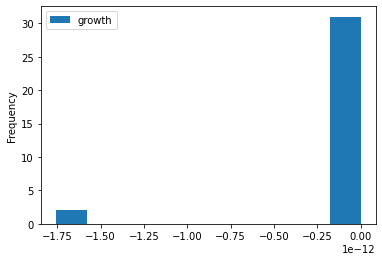

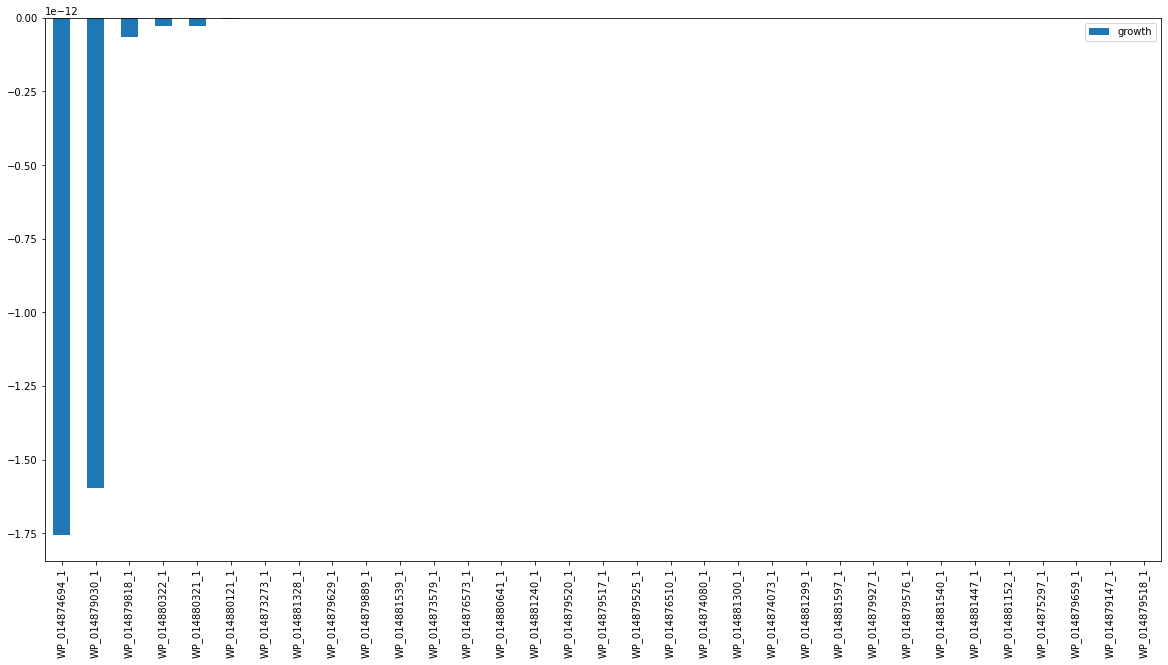

In [51]:
# histogram of the essential genes:

import pandas as pd

df = pd.DataFrame.from_dict(esn_gene, orient='index')
df = df.rename(columns={0: 'growth'})
df = df.sort_values('growth')
df.plot.hist()

ax = df.plot.bar().axes
ax.figure.set_size_inches(20, 10)

In [54]:
#ADDITION OF PRODUCTION OF TDA INTO THE GSM AND SEEING THE POTENTIAL:
# change the medium to the condition silimar with literature.
with model:
    medium = model.medium
    medium['EX_glc__D_e']= 11.11
    medium['EX_pi_e'] = 0.15
    model.medium = medium
    print(medium)
    print("Objective function:",model.objective)
    maxgrowth = model.optimize().objective_value ##NB! Need CPLEX optimizer dependency!!!##
    print("Max growth rate:",maxgrowth)
    new_reaction = Reaction('TDAF') # acser_c + h2o_c + nad_c + pac_c + so4_c --> nadh_c + ppa_c + pyr_c + tda_c
    new_exchange_reaction = Reaction('EX_tda_e') # Exchange reaction for TDA
    tda = Metabolite(id='tda_c', name='tropodithietic acid', compartment='c')
    
    new_reaction.add_metabolites({model.metabolites.so4_c: -1,
                                  model.metabolites.acser_c: -1,
                                  model.metabolites.pac_c: -1,
                                  model.metabolites.nad_c: -1,
                                  model.metabolites.h2o_c: -1,
                                  tda: 1, 
                                  model.metabolites.nadh_c: 1,
                                  model.metabolites.ppa_c: 1,
                                  model.metabolites.pyr_c: 1,
                                 })
    new_exchange_reaction.add_metabolites({tda: -1
                                          })

    
    model.add_reactions([new_reaction])
    model.add_reactions([new_exchange_reaction])
    print(new_reaction.build_reaction_string())
    print(new_exchange_reaction.build_reaction_string())
    model.objective = model.reactions.EX_tda_e #change objective function to the TDA exchange reaction.
    max_tda = model.optimize().objective_value ##NB! Need CPLEX optimizer dependency!!!##
    print(max_tda)

{'EX_adn_e': 10.0, 'EX_ala__L_e': 10.0, 'EX_arg__L_e': 10.0, 'EX_aso3_e': 10.0, 'EX_asp__L_e': 10.0, 'EX_ca2_e': 10.0, 'EX_cl_e': 10.0, 'EX_cobalt2_e': 10.0, 'EX_cu2_e': 10.0, 'EX_cys__L_e': 10.0, 'EX_fe2_e': 10.0, 'EX_fe3_e': 10.0, 'EX_fol_e': 10.0, 'EX_glc__D_e': 11.11, 'EX_glu__L_e': 10.0, 'EX_gly_e': 10.0, 'EX_gsn_e': 10.0, 'EX_h2o_e': 10.0, 'EX_h2s_e': 10.0, 'EX_h_e': 10.0, 'EX_his__L_e': 10.0, 'EX_hxan_e': 10.0, 'EX_ile__L_e': 10.0, 'EX_k_e': 10.0, 'EX_leu__L_e': 10.0, 'EX_lys__L_e': 10.0, 'EX_met__L_e': 10.0, 'EX_mg2_e': 10.0, 'EX_mn2_e': 10.0, 'EX_mobd_e': 10.0, 'EX_nh4_e': 10.0, 'EX_o2_e': 10.0, 'EX_phe__L_e': 10.0, 'EX_pheme_e': 10.0, 'EX_pi_e': 0.15, 'EX_pro__L_e': 10.0, 'EX_ser__L_e': 10.0, 'EX_so4_e': 10.0, 'EX_thm_e': 10.0, 'EX_thr__L_e': 10.0, 'EX_trp__L_e': 10.0, 'EX_tyr__L_e': 10.0, 'EX_uri_e': 10.0, 'EX_val__L_e': 10.0, 'EX_zn2_e': 10.0}
Objective function: Maximize
1.0*Growth - 1.0*Growth_reverse_699ae
Max growth rate: 0.15211546983903795


NameError: name 'Reaction' is not defined

In [57]:
#Keep 20% gowth and maximize PDA production:
with model:
    medium = model.medium
    medium['EX_glc__D_e']= 11.11
    medium['EX_pi_e'] = 0.15
    model.medium = medium
    print(medium)
    print("Objective function:",model.objective)
    maxgrowth = model.optimize().objective_value ##NB! Need CPLEX optimizer dependency!!!##
    print("Max growth rate:",maxgrowth)
    twentygrowth=maxgrowth*0.2
    print("20% growth=",twentygrowth)
    new_reaction = Reaction('TDAF') # acser_c + h2o_c + nad_c + pac_c + so4_c --> nadh_c + ppa_c + pyr_c + tda_c
    new_exchange_reaction = Reaction('EX_tda_e') # Exchange reaction for TDA
    tda = Metabolite(id='tda_c', name='tropodithietic acid', compartment='c')
    
    new_reaction.add_metabolites({model.metabolites.so4_c: -1,
                                  model.metabolites.acser_c: -1,
                                  model.metabolites.pac_c: -1,
                                  model.metabolites.nad_c: -1,
                                  model.metabolites.h2o_c: -1,
                                  tda: 1, 
                                  model.metabolites.nadh_c: 1,
                                  model.metabolites.ppa_c: 1,
                                  model.metabolites.pyr_c: 1,
                                 })
    new_exchange_reaction.add_metabolites({tda: -1
                                          })
    
    model.add_reactions([new_reaction])
    model.add_reactions([new_exchange_reaction])
    model.reactions.Growth.lower_bound = twentygrowth # change the growth rate to 20%.
    print(new_reaction.build_reaction_string())
    print(new_exchange_reaction.build_reaction_string())
    model.objective = model.reactions.EX_tda_e #change objective function to the TDA exchange reaction.
    reasonable_tda = model.optimize().objective_value ##NB! Need CPLEX optimizer dependency!!!##
    print(reasonable_tda)

{'EX_adn_e': 10.0, 'EX_ala__L_e': 10.0, 'EX_arg__L_e': 10.0, 'EX_aso3_e': 10.0, 'EX_asp__L_e': 10.0, 'EX_ca2_e': 10.0, 'EX_cl_e': 10.0, 'EX_cobalt2_e': 10.0, 'EX_cu2_e': 10.0, 'EX_cys__L_e': 10.0, 'EX_fe2_e': 10.0, 'EX_fe3_e': 10.0, 'EX_fol_e': 10.0, 'EX_glc__D_e': 11.11, 'EX_glu__L_e': 10.0, 'EX_gly_e': 10.0, 'EX_gsn_e': 10.0, 'EX_h2o_e': 10.0, 'EX_h2s_e': 10.0, 'EX_h_e': 10.0, 'EX_his__L_e': 10.0, 'EX_hxan_e': 10.0, 'EX_ile__L_e': 10.0, 'EX_k_e': 10.0, 'EX_leu__L_e': 10.0, 'EX_lys__L_e': 10.0, 'EX_met__L_e': 10.0, 'EX_mg2_e': 10.0, 'EX_mn2_e': 10.0, 'EX_mobd_e': 10.0, 'EX_nh4_e': 10.0, 'EX_o2_e': 10.0, 'EX_phe__L_e': 10.0, 'EX_pheme_e': 10.0, 'EX_pi_e': 0.15, 'EX_pro__L_e': 10.0, 'EX_ser__L_e': 10.0, 'EX_so4_e': 10.0, 'EX_thm_e': 10.0, 'EX_thr__L_e': 10.0, 'EX_trp__L_e': 10.0, 'EX_tyr__L_e': 10.0, 'EX_uri_e': 10.0, 'EX_val__L_e': 10.0, 'EX_zn2_e': 10.0}
Objective function: Maximize
1.0*Growth - 1.0*Growth_reverse_699ae
Max growth rate: 0.15211546983903795
20% growth= 0.03042309396780

NameError: name 'Reaction' is not defined

In [58]:
###TESTING GSM MODEL AGAINST DATA FROM LITERATURE：
#Calculating experimental growth rate

import matplotlib.pyplot as plt
import pandas as pd
import scipy
import numpy as np

In [60]:
data_bio = pd.read_csv("data_bio.csv")
print(data_bio)

    Time (h)   CDW (g/L)
0       1.93        0.01
1       3.94        0.02
2       6.15        0.02
3       8.07        0.03
4       9.82        0.03
5      11.74        0.04
6      13.94        0.05
7      16.42        0.06
8      17.98        0.08
9      19.82        0.10
10     21.74        0.13
11     23.67        0.19
12     26.06        0.24
13     27.52        0.28
14     30.18        0.33
15     32.02        0.42
16     33.76        0.51
17     35.96        0.60
18     38.17        0.63
19     40.00        0.60
20     47.80        0.54
21     51.93        0.55


In [61]:
from scipy.optimize import curve_fit

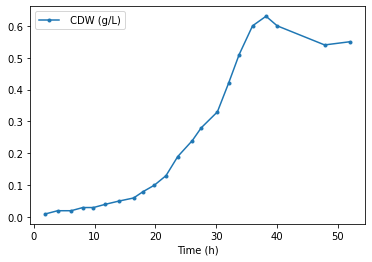

In [62]:
data_bio.plot(x='Time (h)', style='.-');
#important to have the x-variable first.
#keep in mind the order because the answers are shown in the same order

In [65]:
#the exponential fit growth for biomass is:        f=a* exp(mu_max * t)
#a is biomass concentration at t0
#mu is mu_max, maximum biomass growth rate

f= lambda t,a,mu: a*np.exp(mu*t)

exponentialtime= data_bio.loc[11:17, 'Time (h)']


In [66]:
exponentialbiomass= [0.19,0.24,0.28,0.33,0.42,0.51,0.6]

popt,pcof=curve_fit(f, exponentialtime, exponentialbiomass)

In [64]:
#popt contains a and mu, pcof is the covariance

#a=0.008 and mu=0.237 because of the order stablished before

x0=popt[0]

mu=popt[1]

print('Growth rate : ',mu,'(h-1)') 

Growth rate :  0.9999999280587185 (h-1)
